#### Neuron Initialization
Import modules and setup simulation parameters

In [1]:
from neuron import h
import pandas as pd
import numpy as np
import h5py

from cell_inference.cells.stylizedcell import StylizedCell, CellTypes
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.ecp import EcpMod, move_position
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.utils.currents.pointcurrent import PointCurrent

from cell_inference.config import params, paths


h.load_file('stdrun.hoc')
h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

#### Create simulation
Set parameters

In [2]:
elec_pos = params.ELECTRODE_POSITION #pos = np.column_stack((x,y,z))
loc_param = [50,0,0,0.2,1,1.5]  # example position
geo_param = [8.86,153.0,.51,.18,.4,190.]  # choose trunk length [-1,600], bounds([3,12],[20,800],[0.2,1.0],[0.2,1.0],[0.2,1.0],[100,300])

# Change the Cell Type Here
cell_type = CellTypes.ACTIVE

if cell_type == CellTypes.ACTIVE:
    biophys = [-1]#,-1,0.0000589*3,-1,0.0213*1.5]
    sim = Simulation(geometry = geo_standard, 
                     electrodes = elec_pos, 
                     cell_type = CellTypes.ACTIVE, 
                     loc_param = loc_param, 
                     geo_param = geo_param, 
                     biophys = biophys, 
                     gmax = .005, 
                     scale = 100000.)  # 0.001 -0.012
else:
    hf = h5py.File(paths.INVIVO_DATA_FILE, 'r')
    groundtruth_lfp = np.array(hf.get('data'))
    hf.close()
    maxIndx = np.argmax(np.absolute(groundtruth_lfp).max(axis=0))  # find maximum absolute value from averaged traces
    maxTrace = -groundtruth_lfp[params.START_IDX:,maxIndx]
    soma_injection = np.insert(maxTrace,0,0.)
    soma_injection = np.asarray([s * params.SOMA_INJECT_SCALING_FACTOR for s in soma_injection])
    sim = Simulation(geometry = geo_standard,
                     electrodes = params.ELECTRODE_POSITION,
                     cell_type = CellTypes.PASSIVE, 
                     loc_param = loc_param,
                     geo_param = geo_param,
                     soma_injection = soma_injection,
                     ncell = 1) 

Record membrane voltage at initial/middle/end of the trunk and middle of the tuft to check the propagation.

In [15]:
sec_list = sim.cells[0].all
soma_v = sim.cells[0].v()
dend_v = Recorder([sec_list[5](0.1),sec_list[5](0.5),sec_list[5](0.9),sec_list[6](0.5)])
axial_current = soma_v - dend_v.as_numpy()[0,:]

In [16]:
sim.run_neuron_sim()
lfp = sim.get_lfp().T
t = sim.t()

Plot membrane voltage in soma, trunk and tuft.

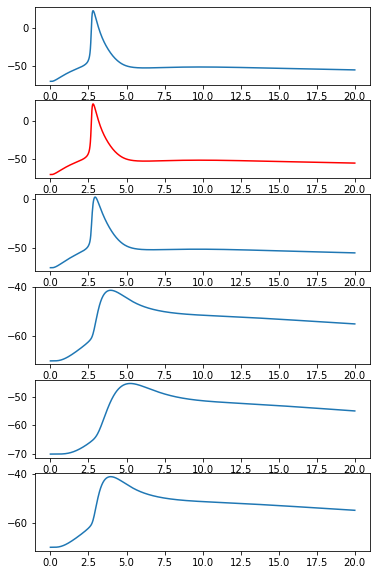

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

v_dend = dend_v.as_numpy()
plt.figure(figsize=(6,10))
plt.subplot(6,1,1)
plt.plot(t,sim.cells[0].v())
plt.subplot(6,1,2)
plt.plot(t, axial_current, color='red')
for i in range(v_dend.shape[0]):
    plt.subplot(6,1,i+3)
    plt.plot(t,v_dend[i,:])
plt.show()

Use functions in "utils" module to plot

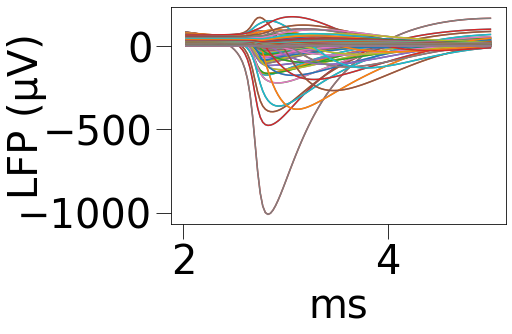

In [6]:
from cell_inference.utils.plotting.plot_results import plot_lfp_traces,plot_lfp_heatmap
%matplotlib inline

delay = 2.0
window = [delay,delay+3.01]
# window = [5.,15.01]
idx = (t>=window[0]) & (t<=window[1])  # time index
fig,ax = plot_lfp_traces(t[idx],lfp[idx,:])

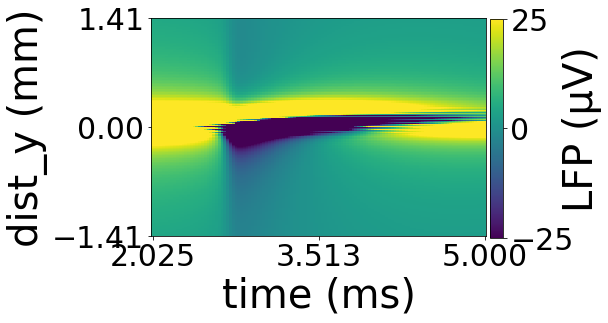

In [10]:
e_idx = slice(50,-50)  # electrodes index
fig,ax = plot_lfp_heatmap(t[idx],elec_pos[e_idx,1],lfp[idx,e_idx],vlim=[-25.,25.])
# set narrower "vlim" can help see more subtle difference in voltage

In [8]:
help(plot_lfp_heatmap) # check docstring

Help on function plot_lfp_heatmap in module cell_inference.utils.plotting.plot_results:

plot_lfp_heatmap(t: numpy.ndarray, elec_d: numpy.ndarray, lfp: numpy.ndarray, savefig: Union[str, NoneType] = None, vlim: str = 'auto', fontsize: int = 40, ticksize: int = 30, labelpad: int = -12, nbins: int = 3, cbbox: Union[List[float], NoneType] = None, cmap: str = 'viridis') -> Tuple[matplotlib.figure.Figure, matplotlib.axes._axes.Axes]
    Plot LFP heatmap.
    t: time points (ms). 1D array
    elec_d: electrode distance (um). 1D array
    lfp: LFP traces (uV). If is 2D array, each column is a channel.
    savefig: if specified as string, save figure with the string as file name.
    vlim: value limit for color map, using +/- 3-sigma of lfp for bounds as default. Use 'max' for maximum bound range.
    fontsize: size of font for display
    labelpad: Spacing in points from the Axes bounding box including ticks and tick labels.
    tick_length: length between ticks
    nbins: number of bins to c